In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns

## 数据预处理

在这一部分需要读入股票日收益以及基金报告期持仓信息，直接输入报告期和结束日期合并两份数据并计算每日权重。没有做成全自动的原因是内存不够0.0

In [ ]:
# def calculate_daily_weights(group):
#     initial_weight = group['F_PRT_STKVALUETONAV'].iloc[0]
#     pct_changes = group['S_DQ_PCTCHANGE'] / 100 + 1
#     weights = initial_weight * pct_changes.cumprod()
#     return weights

In [ ]:
# def calculate_daily_adjweight(report_date,end_date):
#     report_date = pd.to_datetime(report_date,format='%Y-%m-%d')
#     end_date = pd.to_datetime(end_date,format='%Y-%m-%d')

#     fd = pd.read_csv('hist_holding.csv', parse_dates=['F_PRT_ENDDATE'])
#     fd = fd[ fd['F_PRT_ENDDATE'] >= '2021-12-31']
#     stk =  pd.read_csv('/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/实习生数据/EODPrices.csv',
#                        parse_dates=['TRADE_DT'], 
#                        encoding='gbk')


#     fd= fd[fd['F_PRT_ENDDATE']==report_date]
#     stk = stk[(stk['TRADE_DT'] > report_date) & (stk['TRADE_DT'] <=end_date)]
#     df=pd.merge(fd,stk,left_on='S_INFO_STOCKWINDCODE',right_on='S_INFO_WINDCODE')
#     df = df.sort_values(['S_INFO_WINDCODE_x', 'S_INFO_WINDCODE_y', 'TRADE_DT'])
#     df['daily_weight'] = df.groupby(['S_INFO_WINDCODE_x', 'S_INFO_WINDCODE_y']).apply(calculate_daily_weights).reset_index(level=[0,1], drop=True)

#     # 每日对每只基金的权重进行归一化
#     df['normalized_weight'] = df.groupby(['S_INFO_WINDCODE_x', 'TRADE_DT'])['daily_weight'].transform(lambda x: x / x.sum())
#     output_columns = ['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE', 'S_INFO_WINDCODE_x', 'F_PRT_STKVALUETONAV', 
#                   'TRADE_DT', 'S_DQ_PCTCHANGE', 'daily_weight','normalized_weight']

#     return df[output_columns]

## 定义需要的类和函数

In [2]:
#计算全市股票收益率
class ashareeodprice():
    def __init__(self,asharepath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/ashare_nost.csv') -> None:
        self.asharepath=asharepath
        self.ashare_data=None
    
    def read_data(self):
        self.ashare_data = pd.read_csv(self.asharepath, 
        parse_dates=['TRADE_DT','F_PRT_ENDDATE'],encoding='gbk')
        # self.data.sort_values('TRADE_DT', inplace=True)
    
    def get_daily_return_for_stock(self,start_date,end_date):
        filtered_data = self.ashare_data[(self.ashare_data['TRADE_DT']>start_date) 
                                         & (self.ashare_data['TRADE_DT']<= end_date)]
        return filtered_data


In [3]:
#构建持仓信息
class fundportfolio():
    def __init__(self, portfoliopath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/fund_2303to2403.csv') -> None:
        self.portfoliopath = portfoliopath
        self.portfolio_data = None
        
    def read_data(self):
        try:
            self.portfolio_data = pd.read_csv(self.portfoliopath, parse_dates=['F_PRT_ENDDATE'])
            # 确保日期格式一致
            self.portfolio_data['F_PRT_ENDDATE'] = pd.to_datetime(self.portfolio_data['F_PRT_ENDDATE'], format='%Y-%m-%d')
            self.portfolio_data.sort_values('F_PRT_ENDDATE', inplace=True)
            print("Data read successfully. Sample data:\n", self.portfolio_data.head())
        except Exception as e:
            print(f"Error reading data: {e}")
            raise

    def filter_data_by_enddate(self, enddate_str):
        """根据日期过滤数据"""
        if self.portfolio_data is None:
            raise ValueError("数据未加载，请先调用 read_data() 方法加载数据。")
        if not pd.api.types.is_datetime64_any_dtype(self.portfolio_data['F_PRT_ENDDATE']):
            raise TypeError("F_PRT_ENDDATE 列不是日期类型，请检查数据格式。")
        
        # 使用局部变量存储过滤结果
        filtered_data = self.portfolio_data[self.portfolio_data['F_PRT_ENDDATE'].dt.strftime('%Y-%m-%d') == enddate_str]
        return filtered_data

    def top_holdings_by_fund(self, data, fund_code):
        """选出特定基金持仓权重前top_n的股票"""
        fund_data = data[data['S_INFO_WINDCODE'] == fund_code]
        top_holdings = fund_data.sort_values(by='F_PRT_STKVALUETONAV', ascending=False)
        return top_holdings
    
    def remove_funds_with_hk_stocks(self, data):
        """删除持有港股的基金"""
        hk_stocks_funds = data[data['S_INFO_STOCKWINDCODE'].str.endswith('HK')]['S_INFO_WINDCODE'].unique()
        data = data[~data['S_INFO_WINDCODE'].isin(hk_stocks_funds)]
        return data

    def top_holdings_for_all_funds(self, data):
        """选出所有基金持仓权重前top_n的股票"""
        data = self.remove_funds_with_hk_stocks(data)
        all_top_holdings = pd.DataFrame()
        fund_codes = data['S_INFO_WINDCODE'].unique()
        for fund_code in fund_codes:
            top_holdings = self.top_holdings_by_fund(data, fund_code)
            all_top_holdings = pd.concat([all_top_holdings, top_holdings])
        return all_top_holdings
    
    def filter_and_top_holdings_for_all_funds(self, enddate_str):
        """筛选出指定日期的所有基金持仓权重前top_n的股票"""
        filtered_data = self.filter_data_by_enddate(enddate_str)
        if filtered_data.empty:
            print(f"No data found for {enddate_str}.")
            return pd.DataFrame()

        # 使用局部变量而非类属性
        top_holdings = self.top_holdings_for_all_funds(filtered_data)
        return top_holdings

In [4]:
# 定义一个函数来计算每个基金的收益率
def calculate_return(group):
    # 找到期初净值和期末净值
    initial_nav = group.iloc[-1]['F_NAV_ADJUSTED']
    final_nav = group.iloc[0]['F_NAV_ADJUSTED']
    # 计算收益率
    return_rate = (final_nav/ initial_nav)-1 
    return pd.Series({'Longterm_Return_Fund': return_rate})



In [5]:
#计算基金收益率
class fundreturns:
    def __init__(self,fundreturnpath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/ChinaMutualFundNAV_NEW.CSV') -> None:
        self.fundreturnpath=fundreturnpath
        self.fundreturn_data=[]
    
    def get_data(self):
        self.fundreturn_data = pd.read_csv(self.fundreturnpath,parse_dates=['PRICE_DATE'],
                                           dtype={'F_INFO_WINDCODE':str,'F_NAV_ADJUSTED':float},
                                           low_memory=False)
        self.fundreturn_data = self.fundreturn_data.dropna()
    
    def calculate_return_for_fund(self,start_date, end_date):
        """计算特定基金在报告期的收益率"""
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        filtered_data = self.fundreturn_data[
                                  (self.fundreturn_data['PRICE_DATE'] >= start_date)&
                                   (self.fundreturn_data['PRICE_DATE']<=end_date) ]

        if filtered_data.empty:
            return None
        # 使用 groupby 按基金编号分组，并应用计算收益率的函数
        returns = filtered_data.groupby('F_INFO_WINDCODE').apply(calculate_return).reset_index()

        return returns
    
    def calculate_daily_returns_for_funds(self,start_date, end_date):
        filtered_data = self.fundreturn_data[
                            (self.fundreturn_data['PRICE_DATE'] >= start_date)&
                            (self.fundreturn_data['PRICE_DATE']<=end_date) ]
        # 确保数据按照基金代码和日期排序
        filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
        filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()

        # 删除含有NaN值的行
        filtered_data.dropna(subset=['Daily_Return_Fund'], inplace=True)

        return filtered_data[['F_INFO_WINDCODE', 'PRICE_DATE', 'Daily_Return_Fund']]


In [6]:
#定义IR的计算方式，用于arregation func
def ir(series):
    return series.mean()/series.std()

## 船新版本

In [10]:
def calcualte_4T_IR(report_date,current_date):
    aggregated_df_4T=[]
    stock = ashareeodprice(asharepath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/daily_change_all.csv')
    stock.read_data()

    # fundportfolio1 = fundportfolio(portfoliopath='hist_holding.csv')
    # fundportfolio1.read_data()

    fundreturn = fundreturns(fundreturnpath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/实习生数据/ChinaMutualFundNAV.csv')
    fundreturn.get_data()
    
    month_offsets = [0, 3, 6, 9]
    for months in month_offsets:
        # 计算新的报告日期
        adjusted_date = report_date - relativedelta(months=months)
        adjusted_date = adjusted_date + relativedelta(day=31)
        
        adjusted_date_end = adjusted_date + relativedelta(months=3, day=31)
        
        if current_date <= adjusted_date_end:
            adjusted_date_end = current_date

        # 将日期转换为字符串格式
        adjusted_date_str = adjusted_date.strftime('%Y-%m-%d')
        adjusted_date_end_str = adjusted_date_end.strftime('%Y-%m-%d')

        # # 调用 filter_and_top_holdings_for_all_funds 方法并添加到 holding_list
        # holding = fundportfolio1.filter_and_top_holdings_for_all_funds(adjusted_date_str)
        stock_daily_return = stock.get_daily_return_for_stock(adjusted_date_str, adjusted_date_end_str)
        fund_daily_returns_actual = fundreturn.calculate_daily_returns_for_funds(adjusted_date_str, adjusted_date_end_str)

        stock_daily_return['Weighted_Return'] =stock_daily_return['normalized_weight'] * (stock_daily_return['S_DQ_PCTCHANGE']/100  )

        returncalc=pd.merge(fund_daily_returns_actual,
                            stock_daily_return,
                            left_on=['F_INFO_WINDCODE','PRICE_DATE'],
                            right_on=['S_INFO_WINDCODE_x','TRADE_DT'],
                            how='inner')
        returncalc['Excess_Return']=returncalc['Daily_Return_Fund']-returncalc['Weighted_Return']
        df=pd.DataFrame(returncalc.groupby('S_INFO_WINDCODE_x')['Excess_Return'].agg(ir))
        aggregated_df_4T.append(df)

    combined_df = pd.concat(aggregated_df_4T)
    return combined_df

In [11]:
def calculate_rankic_and_save_results(start_date, end_date, output_file):
    results = []

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # 初始化日期
    current_date = start_date

    while current_date <= end_date:
        # 确定报告期
        if current_date.month <= 3:
            report_date = pd.to_datetime(f"{current_date.year-1}-12-31")
        elif current_date.month <= 6:
            report_date = pd.to_datetime(f"{current_date.year}-03-31")
        elif current_date.month <= 9:
            report_date = pd.to_datetime(f"{current_date.year}-06-30")
        else:
            report_date = pd.to_datetime(f"{current_date.year}-09-30")

        # 确定构建期和测试期
        construct_start = report_date + pd.DateOffset(days=1)
        construct_end = current_date
        test_start = construct_end + pd.DateOffset(days=1)
        test_end = test_start + relativedelta(months=3) - pd.DateOffset(days=1)

        # 确保时间线不超出
        if test_end > end_date:
            break

        print(f"报告期: {report_date.strftime('%Y-%m-%d')}")
        print(f"构建期: {construct_start.strftime('%Y-%m-%d')} 至 {construct_end.strftime('%Y-%m-%d')}")
        print(f"测试期: {test_start.strftime('%Y-%m-%d')} 至 {test_end.strftime('%Y-%m-%d')}")

        combined_df=calcualte_4T_IR(report_date,current_date)
        fundreturn=fundreturns(fundreturnpath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/实习生数据/ChinaMutualFundNAV.csv')
        fundreturn.get_data()
        fund_longterm_returns_actual = fundreturn.calculate_return_for_fund(test_start, test_end)

        mean_excess_return = combined_df.groupby('S_INFO_WINDCODE_x')['Excess_Return'].mean()
        mean_excess_return_df = mean_excess_return.reset_index()
        mean_excess_return_df.columns = ['F_INFO_WINDCODE', 'Excess_Return_IR']
        mean_excess_return_df
        result = pd.merge(mean_excess_return_df,fund_longterm_returns_actual , on='F_INFO_WINDCODE', how='inner')
        rankic=result['Excess_Return_IR'].corr(result['Longterm_Return_Fund'],method='spearman')

        # 保存结果到df
        results.append({
            'Report_Date': report_date.strftime('%Y-%m-%d'),
            'Construct_Period': f"{construct_start.strftime('%Y-%m-%d')} to {construct_end.strftime('%Y-%m-%d')}",
            'Test_Period': f"{test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}" ,
            'RankIC': rankic
        })

        # 滑到下一个月
        current_date += pd.DateOffset(months=1,day=31)

    # 保存结果到csv
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)


## 进行测试并可视化

In [12]:
calculate_rankic_and_save_results('2023-01-31', '2024-04-30','test_813_2.csv')

报告期: 2022-12-31
构建期: 2023-01-01 至 2023-01-31
测试期: 2023-02-01 至 2023-04-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2022-12-31
构建期: 2023-01-01 至 2023-02-28
测试期: 2023-03-01 至 2023-05-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2022-12-31
构建期: 2023-01-01 至 2023-03-31
测试期: 2023-04-01 至 2023-06-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-03-31
构建期: 2023-04-01 至 2023-04-30
测试期: 2023-05-01 至 2023-07-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-03-31
构建期: 2023-04-01 至 2023-05-31
测试期: 2023-06-01 至 2023-08-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-03-31
构建期: 2023-04-01 至 2023-06-30
测试期: 2023-07-01 至 2023-09-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-06-30
构建期: 2023-07-01 至 2023-07-31
测试期: 2023-08-01 至 2023-10-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-06-30
构建期: 2023-07-01 至 2023-08-31
测试期: 2023-09-01 至 2023-11-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-06-30
构建期: 2023-07-01 至 2023-09-30
测试期: 2023-10-01 至 2023-12-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-09-30
构建期: 2023-10-01 至 2023-10-31
测试期: 2023-11-01 至 2024-01-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-09-30
构建期: 2023-10-01 至 2023-11-30
测试期: 2023-12-01 至 2024-02-29


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-09-30
构建期: 2023-10-01 至 2023-12-31
测试期: 2024-01-01 至 2024-03-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

报告期: 2023-12-31
构建期: 2024-01-01 至 2024-01-31
测试期: 2024-02-01 至 2024-04-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_60933/2758545255.py:42: SettingWithCopyWarning: 
A value is tryin

In [3]:
result=pd.read_csv('test_813_2.csv' , parse_dates=['Time'])
result

/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_36072/2719478011.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result=pd.read_csv('test_813_2.csv' , parse_dates=['Time'])


,Report_Date,Construct_Period,Test_Period,RankIC,Benchmark,Time
0,2022/12/31,2023-01-01 to 2023-01-31,2023-02-01 to 2023-04-30,0.02,-0.01,202301
1,2022/12/31,2023-01-01 to 2023-02-28,2023-03-01 to 2023-05-31,0.11,0.02,202302
2,2022/12/31,2023-01-01 to 2023-03-31,2023-04-01 to 2023-06-30,0.14,0.09,202303
3,2023/3/31,2023-04-01 to 2023-04-30,2023-05-01 to 2023-07-31,-0.12,-0.07,202304
4,2023/3/31,2023-04-01 to 2023-05-31,2023-06-01 to 2023-08-31,-0.28,-0.19,202305
5,2023/3/31,2023-04-01 to 2023-06-30,2023-07-01 to 2023-09-30,-0.04,-0.12,202306
6,2023/6/30,2023-07-01 to 2023-07-31,2023-08-01 to 2023-10-31,0.17,-0.08,202307
7,2023/6/30,2023-07-01 to 2023-08-31,2023-09-01 to 2023-11-30,0.08,0.01,202308
8,2023/6/30,2023-07-01 to 2023-09-30,2023-10-01 to 2023-12-31,0.14,0.08,202309
9,2023/9/30,2023-10-01 to 2023-10-31,2023-11-01 to 2024-01-31,-0.07,-0.05,202310


In [4]:
result = result.iloc[0:12,:]


In [5]:
df = result 
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m').dt.strftime('%Y-%m')

/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_36072/3000740349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['Time'], format='%Y%m').dt.strftime('%Y-%m')


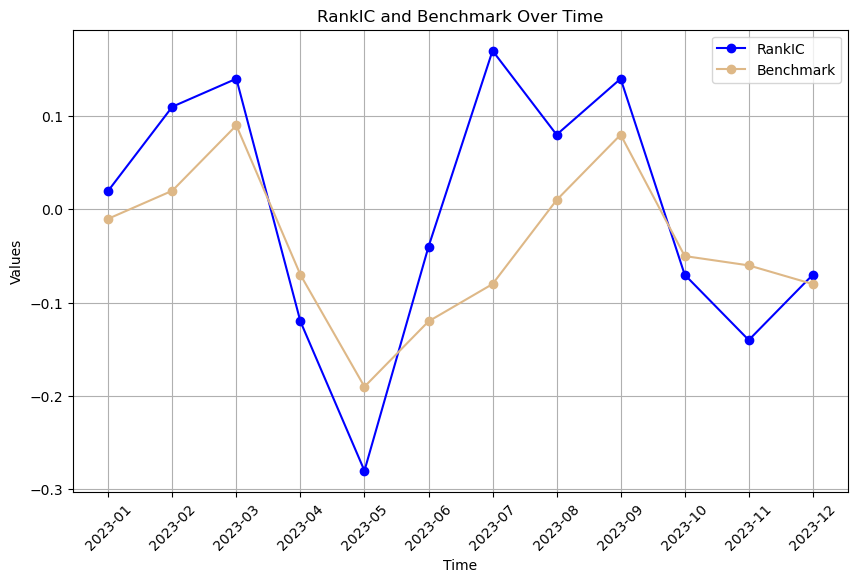

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['RankIC'], marker='o', label='RankIC', color='blue')
plt.plot(df['Time'], df['Benchmark'], marker='o', label='Benchmark', color='burlywood')

plt.title('RankIC and Benchmark Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()